In [1]:
import pandas as pd

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torchvision

In [4]:
import torch

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
random_seed = 0
torch.manual_seed(random_seed)

In [9]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class GenCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 64 x 50 x 50
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 128 x 25 x 25
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 256 x 12 x 12
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 512 x 6 x 6
            
            nn.Flatten(),
            nn.Linear(512*6*6, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [11]:
model = GenCnnModel()

In [12]:
model.load_state_dict(torch.load('genClass-Cnn.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
image = Image.open('male.jpg').convert("RGB")
tensor_image = transform(image)

In [24]:
tensor_image

tensor([[[1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 0.9961],
         [0.9961, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9961],
         ...,
         [1.0000, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961]],

        [[1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 0.9961],
         [0.9961, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9961],
         ...,
         [1.0000, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 0.9961]],

        [[1.0000, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 1.0000, 0.9961,  ..., 0.9961, 1.0000, 0.9961],
         [0.9961, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.

In [7]:
transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

In [17]:
# class CustomDataSet(Dataset):
#     def __init__(self, main_dir, transform):
#         self.main_dir = main_dir
#         self.transform = transform
#         all_imgs = os.listdir(main_dir)
#         # self.total_imgs = natsort.natsorted(all_imgs)

#     def __len__(self):
#         return len(self.total_imgs)

#     def __getitem__(self, idx):
#         img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
#         image = Image.open(img_loc).convert("RGB")
#         tensor_image = self.transform(image)
#         return tensor_image

In [21]:
import os
# import natsort
from PIL import Image

In [51]:
image1 = Image.open('aaa.jpg').convert("RGB")
tensor_image1 = transform(image1)

In [62]:
image2 = Image.open('fem.jpg').convert("RGB")
tensor_image2 = transform(image2)

In [65]:
image3 = Image.open('dc.jpg').convert("RGB")
tensor_image3 = transform(image3)

In [70]:
def predict(image, model):
    xb = image.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    
    if (preds[0].item() == 0):
        return "female"
    elif (preds[0].item() == 1):
        return "male"
    

Label:  female


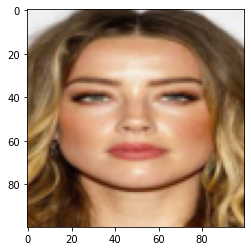

In [72]:
plt.imshow(tensor_image3.permute(1,2,0))
print("Label: ", predict(tensor_image3, model))